In [299]:
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("../src")

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f"Shape of DBTL cycle 1: {df_A.shape} and DBTL cycle 2: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds


bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Shape of DBTL cycle 1: (27, 10) and DBTL cycle 2: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


In [322]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,H2)
        self.linear3=nn.Linear(H2,H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        
        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.linear5=nn.Linear(H2,H)
        self.linear6=nn.Linear(H,D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu((self.linear1(x)))
        lin2 = self.relu((self.linear2(lin1)))
        lin3 = self.relu((self.linear3(lin2)))

        fc1 = F.relu((self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu((self.fc3(z)))
        fc4 = self.relu((self.fc4(fc3)))

        lin4 = self.relu((self.linear4(fc4)))
        lin5 = self.relu((self.linear5(lin4)))
        return (self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

D_in = df_A.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = customLoss()

epochs = 10000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    x = torch.tensor(df_A.values).float().to(device)
    x_recon, mu, logvar = model(x)
    loss = loss_mse(x_recon, x, mu, logvar)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")


Epoch 0 Loss 50978.765625


Epoch 500 Loss 1189.0103759765625
Epoch 1000 Loss 624.1441650390625
Epoch 1500 Loss 549.2027587890625
Epoch 2000 Loss 511.8145751953125
Epoch 2500 Loss 426.4742431640625
Epoch 3000 Loss 406.603759765625
Epoch 3500 Loss 358.33721923828125
Epoch 4000 Loss 377.84197998046875
Epoch 4500 Loss 358.85272216796875
Epoch 5000 Loss 357.78704833984375
Epoch 5500 Loss 331.3048095703125
Epoch 6000 Loss 314.979248046875
Epoch 6500 Loss 297.6456604003906
Epoch 7000 Loss 309.503173828125
Epoch 7500 Loss 260.066650390625
Epoch 8000 Loss 231.54714965820312
Epoch 8500 Loss 189.7060546875
Epoch 9000 Loss 199.7444305419922
Epoch 9500 Loss 170.26068115234375


In [324]:
# GEt the latend space representation
model.eval()
x = torch.tensor(df_A.values).float().to(device)
mu, logvar = model.encode(x)
z = model.reparameterize(mu, logvar)
z

tensor([[ 0.5503, -1.1788,  1.7474],
        [-0.2497, -0.1624, -0.1463],
        [-0.4071, -0.1796, -0.5101],
        [-0.7500, -1.3735, -1.2555],
        [ 0.3619,  0.4199,  1.2461],
        [-0.7812, -1.2123, -1.3341],
        [ 0.3208, -0.6815,  1.1957],
        [-0.1709, -0.3630,  0.0444],
        [ 0.5289,  0.6958,  1.6216],
        [ 0.9621,  0.8092,  2.6200],
        [ 0.0502, -0.4896,  0.5615],
        [ 0.2751, -0.8850,  1.0982],
        [ 0.0028, -0.5674,  0.4548],
        [-0.5592,  0.1954, -0.8774],
        [-0.4557,  0.3816, -0.6453],
        [-0.4377,  0.0280, -0.5892],
        [-0.1099,  0.3878,  0.1551],
        [-0.2888, -0.1930, -0.2356],
        [-0.0485,  0.4938,  0.2928],
        [-0.2293, -0.9356, -0.0675],
        [-0.1516, -0.4463,  0.0924],
        [ 0.8979, -0.3636,  2.5191],
        [-0.1580, -0.5666,  0.0825],
        [-0.2330, -0.9896, -0.0739],
        [-0.7298, -0.5553, -1.2419],
        [-0.6985, -0.3290, -1.1787],
        [ 0.2835,  0.7113,  1.0528]], 

# Model selection (NCV)

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

# ## Uncomment to run model selection
# modelSelection(X_train, y_train)

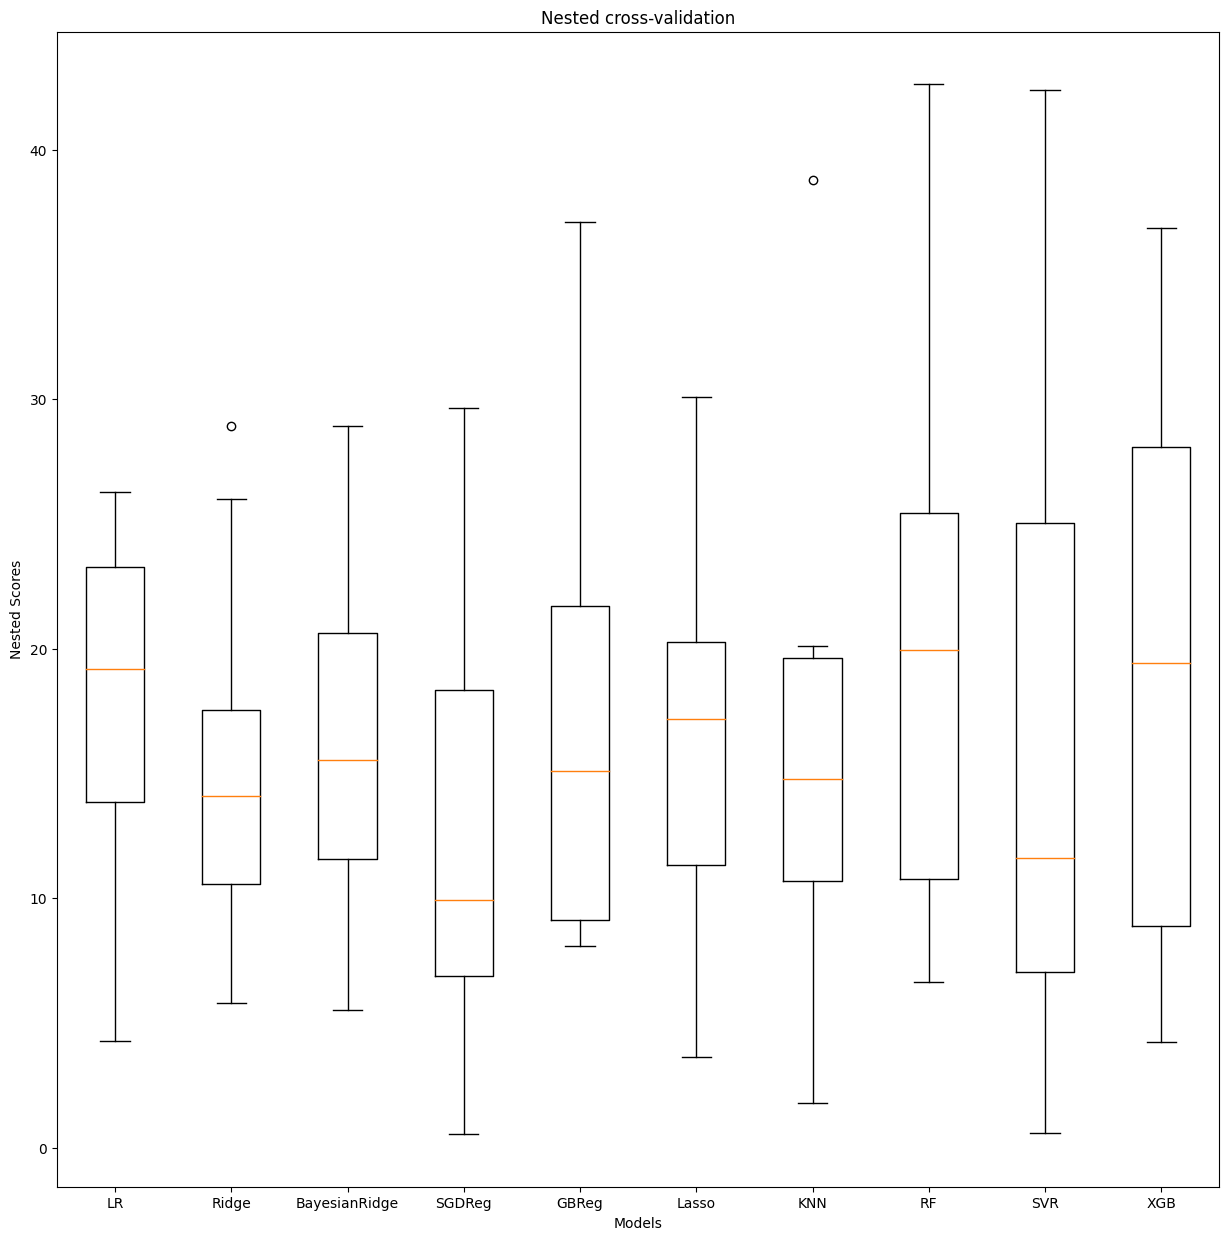

# ML training (Optuna)

In [ ]:
# import optuna
# from sklearn.svm import SVR
# from sklearn.model_selection import cross_val_score


# def objective(trial):
#     # Define the hyperparameters to optimize
#     C = trial.suggest_loguniform("C", 0.01, 100)
#     epsilon = trial.suggest_loguniform("epsilon", 0.01, 1)
#     gamma = trial.suggest_loguniform("gamma", 0.001, 1)
#     kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
#     degree = trial.suggest_int("degree", 2, 5)

#     # Create the SVR model with the hyperparameters
#     model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel, degree=degree)
#     scores = cross_val_score(
#         model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
#     )
#     return -scores.mean()


# # Create the study object and optimize the objective function
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)
# best_params = study.best_params
# final_model = SVR(**best_params)
# final_model.fit(X_train, y_train)

In [15]:
import optuna
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-5, 1e-1)
    l1_ratio = trial.suggest_uniform("l1_ratio", 0, 1)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "optimal", "invscaling"])
    eta0 = trial.suggest_loguniform("eta0", 1e-5, 1e-1)
    model = SGDRegressor(alpha=alpha, l1_ratio=l1_ratio, learning_rate=learning_rate, eta0=eta0)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    return -scores.mean()

# Create the study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=800)
best_params = study.best_params
final_model = SGDRegressor(**best_params)
final_model.fit(X_train, y_train)


[I 2024-02-21 21:03:21,138] A new study created in memory with name: no-name-64e2fcc5-fc5f-4cab-9fbd-1d4888e4bd8f


[I 2024-02-21 21:03:21,185] Trial 0 finished with value: 16.092113303983147 and parameters: {'alpha': 1.620400463382608e-05, 'l1_ratio': 0.5736971364140531, 'learning_rate': 'constant', 'eta0': 0.007204078232296395}. Best is trial 0 with value: 16.092113303983147.
[I 2024-02-21 21:03:21,216] Trial 1 finished with value: 19.04353348810855 and parameters: {'alpha': 0.001937899114823153, 'l1_ratio': 0.8055246197032487, 'learning_rate': 'constant', 'eta0': 0.020336486385559342}. Best is trial 0 with value: 16.092113303983147.
[I 2024-02-21 21:03:21,242] Trial 2 finished with value: 1611569305042.5273 and parameters: {'alpha': 0.009721774064606658, 'l1_ratio': 0.6603606071195057, 'learning_rate': 'optimal', 'eta0': 4.642506726300735e-05}. Best is trial 0 with value: 16.092113303983147.
[I 2024-02-21 21:03:21,272] Trial 3 finished with value: 16.407206204384003 and parameters: {'alpha': 0.0001387299395951275, 'l1_ratio': 0.7612789251510157, 'learning_rate': 'constant', 'eta0': 0.000293802284

SGDRegressor(alpha=0.00908758716999893, eta0=0.026128102298350196,
             l1_ratio=0.7372350065712631)

In [21]:
# # Pickle save model
# with open("../models/limonene_model.pkl", "wb") as f:
#     pickle.dump(final_model, f)

# Model evaluation (Bootstrap)

In [4]:
# pickle load model
with open("../models/limonene_model.pkl", "rb") as f:
    final_model = pickle.load(f)

In [5]:
def bootstrap(X, y, model: object, n: int = 100):
    mse_values = []
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
        mse_values.append(mean_squared_error(y_test, y_pred))
    return mae_values, mse_values

mae_values, mse_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
print(f"Bootstraped Mean(MSE) = {np.mean(mse_values)}")

print(f"Bootstraped std(MAE) = {np.std(mae_values)}")
print(f"Bootstraped std(MSE) = {np.std(mse_values)}")

final_model.fit(X_train, y_train)

100%|██████████| 100/100 [00:00<00:00, 174.04it/s]

Bootstraped Mean(MAE) = 17.626657055826954
Bootstraped Mean(MSE) = 570.6626728310571
Bootstraped std(MAE) = 4.636442257035881
Bootstraped std(MSE) = 307.43860269781334


SGDRegressor(alpha=0.00908758716999893, eta0=0.026128102298350196,
             l1_ratio=0.7372350065712631)

# Explainable AI 

  0%|          | 0/27 [00:00<?, ?it/s]

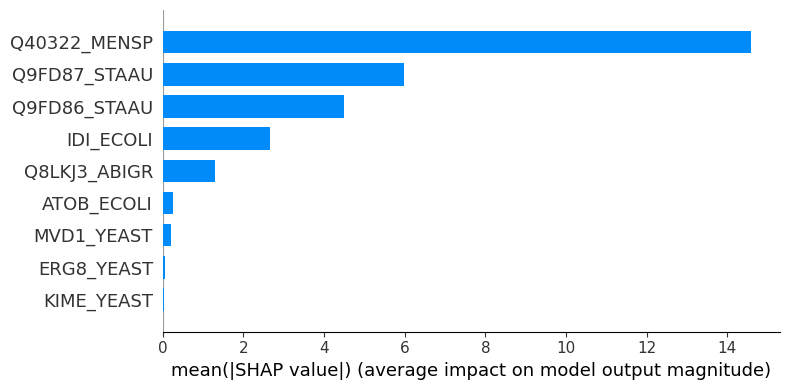

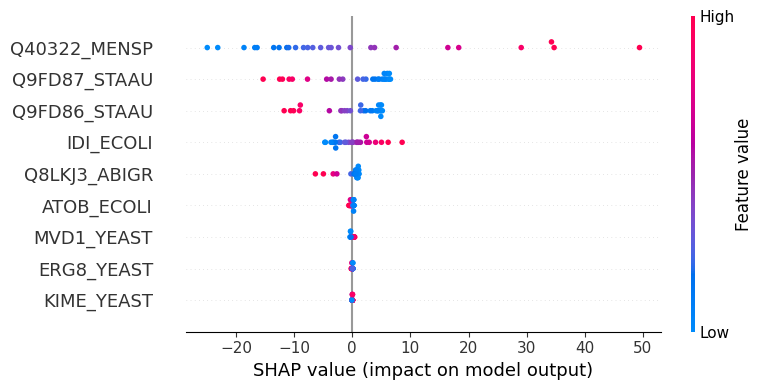

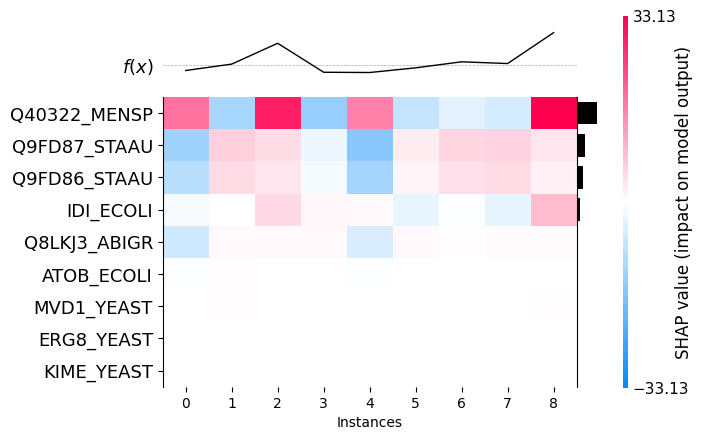

In [6]:
import shap
import matplotlib.pyplot as plt


def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.KernelExplainer(final_model.predict, df_A[INPUT_VARS])
shap_values = shap_explainer(df_A[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = final_model.predict(df_A[INPUT_VARS])
shap_df["true"] = df_A[RESPONSE_VARS].values.ravel()
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(8, 4))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(8, 4))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

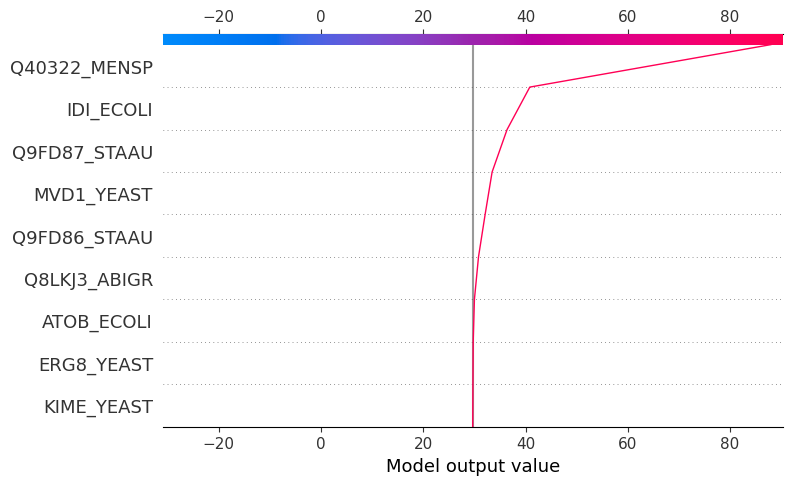

pred    87.967691
true    75.392610
Name: 0, dtype: float64


In [7]:
idx=0
shap.decision_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[idx].values, 
                   INPUT_VARS)

print(shap_df[['pred', 'true']].iloc[idx])

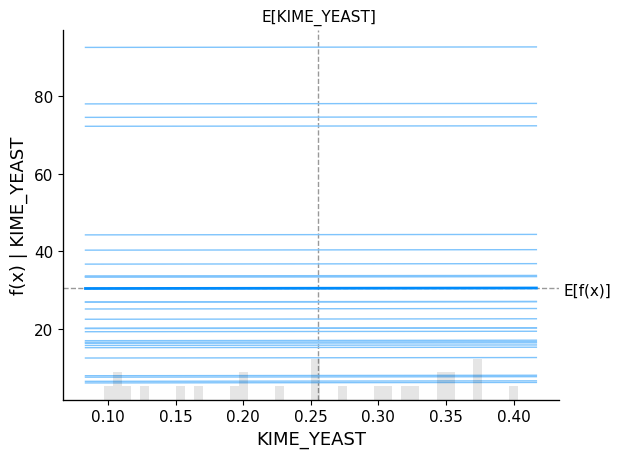

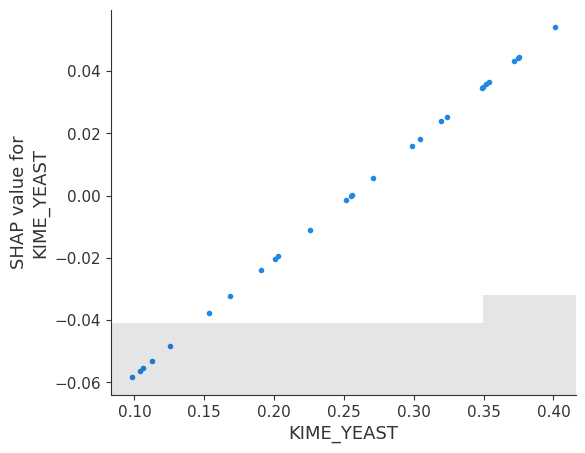

In [18]:
feature = "KIME_YEAST"
pdplot(df_A[INPUT_VARS], feature, final_model, ice=True)
shap_scatter(feature)

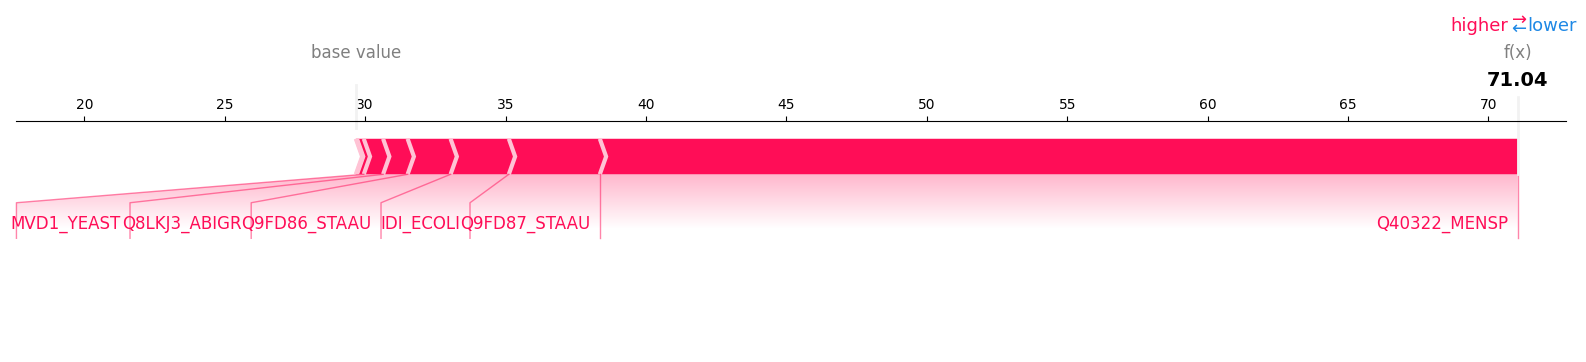

In [9]:
shap.force_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[2].values, 
                   features=INPUT_VARS,
                   matplotlib=True, show=True)

# Lime

In [7]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Limonene"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Limonene", ascending=False, inplace=True)
# Drop rows with Limonene < 0
sample_df = sample_df[sample_df["Limonene"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Limonene"]

In [31]:
sample_df

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
515,1.613101,1.291696,1.871130,0.364287,0.923117,11.726143,1.736593,0.047185,0.329691,107.060560
536,1.115270,0.742418,2.702134,0.253844,1.103502,11.897790,1.597798,0.256122,1.811111,106.659804
411,0.213082,0.712698,2.227670,0.246717,1.365562,11.094619,1.103238,0.503254,0.091883,105.277023
616,0.533115,1.347888,3.047987,0.229759,1.234877,11.941971,4.268578,0.908139,1.443555,105.028776
483,0.469875,0.641870,2.286992,0.114259,2.072067,11.685593,1.758247,0.645808,1.292985,103.976602
...,...,...,...,...,...,...,...,...,...,...
465,1.493486,0.816179,1.204899,0.256157,1.196927,1.238533,3.945445,1.119217,2.345252,1.194580
566,1.145311,0.261843,2.560115,0.281199,1.915116,1.935526,1.660867,3.313116,4.258726,0.942341
898,0.408822,1.486462,2.213901,0.167571,1.536404,2.226803,4.495157,3.143695,3.699059,0.913449
499,0.440323,0.328273,1.122549,0.098405,1.256301,3.266706,4.518520,1.799857,5.544533,0.645469


Intercept 36.84398525702271
Prediction_local [26.36434319]
Right: 29.03640950863846


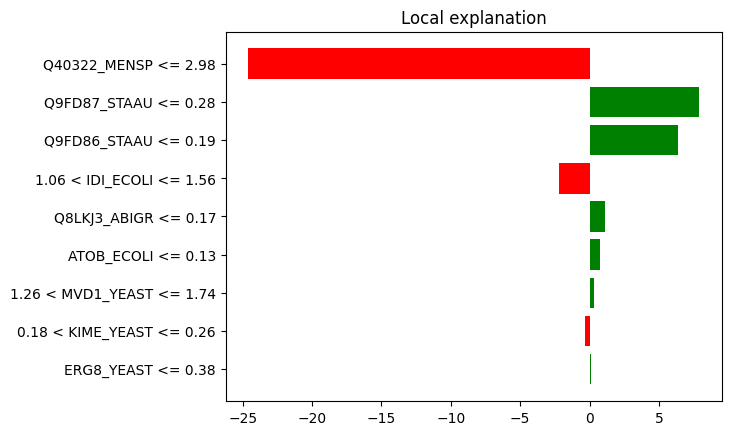

In [68]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=INPUT_VARS,  
                                                   verbose=True, mode='regression')
                                                   
i = 22
exp = explainer.explain_instance(X_train.values[i], final_model.predict)
exp.show_in_notebook(show_table=True, show_all=True)
exp.as_list()
exp.as_pyplot_figure();

# Sampling

Create new `sampling bounds`, to generate/recommend new strain designs.

In [14]:
bounds

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


In [15]:
df_B 

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
BL.Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367
BL.Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494
BL.Ml,0.24012,0.19050,0.94884,0.38070,1.30811,2.72406,0.11237,0.05002,0.08503,6.72018


In [35]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 5.34 # 9.58
sampling_bounds["Q40322_MENSP"].loc["max"] = bounds["Q40322_MENSP"].loc["max"]

sampling_bounds["IDI_ECOLI"].loc["min"] = 1.95
sampling_bounds["IDI_ECOLI"].loc["max"] = bounds["IDI_ECOLI"].loc["max"]

sampling_bounds["Q9FD87_STAAU"].loc["min"] = 0.28 # bounds["Q9FD87_STAAU"].loc["min"]
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 0.75 # bounds["Q9FD87_STAAU"].loc["max"]

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = 1.27 #bounds["Q8LKJ3_ABIGR"].loc["min"]
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 2.51

sampling_bounds["Q9FD86_STAAU"].loc["min"] = 0.19 # bounds["Q9FD86_STAAU"].loc["min"]
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 0.78 # bounds["Q9FD86_STAAU"].loc["max"]

sampling_bounds["MVD1_YEAST"].loc["min"] = 1.74 # bounds["MVD1_YEAST"].loc["min"]
sampling_bounds["MVD1_YEAST"].loc["max"] = bounds["MVD1_YEAST"].loc["max"]

sampling_bounds["ERG8_YEAST"].loc["min"] = bounds["ERG8_YEAST"].loc["min"]
sampling_bounds["ERG8_YEAST"].loc["max"] = bounds["ERG8_YEAST"].loc["max"]

sampling_bounds["ATOB_ECOLI"].loc["min"] = bounds["ATOB_ECOLI"].loc["min"]
sampling_bounds["ATOB_ECOLI"].loc["max"] = bounds["ATOB_ECOLI"].loc["max"]

sampling_bounds["KIME_YEAST"].loc["min"] = bounds["KIME_YEAST"].loc["min"]
sampling_bounds["KIME_YEAST"].loc["max"] = bounds["KIME_YEAST"].loc["max"]


# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)

# Counterfactuals (`DiCE`)

In [133]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:2]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn",model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=3,
    desired_range=[105, 130],
    permitted_range=bounds_to_dict(sampling_bounds),
    features_to_vary="all",
    # proximity_weight=0.4,
    # diversity_weight=0.8,
    # sparsity_weight=0.4
)

cf_df = e1.cf_examples_list[0].final_cfs_df
# e1.visualize_as_dataframe(show_only_changes=False)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:19<00:00,  9.84s/it]


In [134]:
cf_df = pd.DataFrame()
for i in range(len(e1.cf_examples_list)):
    _ = e1.cf_examples_list[i].final_cfs_df
    # Concatenate the dataframes
    cf_df = pd.concat([cf_df, _], axis=0)

cf_df.sort_values('Limonene', ascending=False, inplace=True)
cf_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.1454,0.1899,3.3821,0.2061,1.7400,11.9449,1.2700,0.1900,0.3728,107.835863
0,0.6774,1.1137,3.1855,0.3862,1.9757,12.1130,1.2749,0.2138,0.6343,106.418419
0,0.1454,0.2478,3.3845,0.3075,1.7575,11.9449,1.2700,0.3690,0.5949,106.150689
0,0.1991,0.9845,2.9914,0.3267,2.1776,12.0491,1.6545,0.3846,0.2908,105.387034
0,0.1879,0.9721,3.3652,0.3404,1.8661,12.0228,2.0699,0.5282,0.3894,105.339390
0,0.1925,0.1899,2.9254,0.2942,2.1849,12.1745,1.2700,0.6031,0.4691,105.107279


In [135]:
df_B

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
BL.Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367
BL.Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494
BL.Ml,0.24012,0.19050,0.94884,0.38070,1.30811,2.72406,0.11237,0.05002,0.08503,6.72018


# PCA

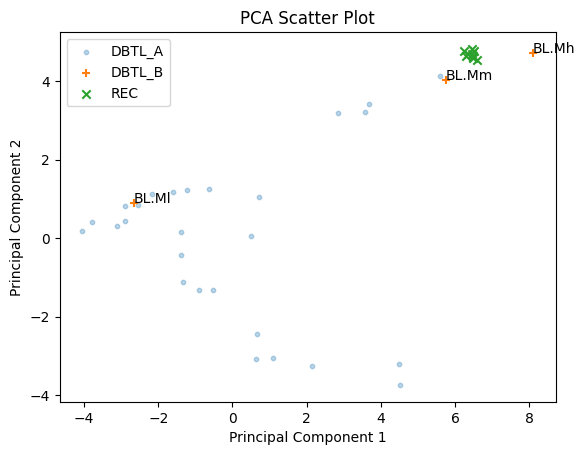

BL.Mh    127.99494
BL.Mm    119.81367
BL.Ml      6.72018
Name: Limonene, dtype: float64


In [136]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(sample_df[INPUT_VARS][:10])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker="+")
for i, txt in enumerate(DBTL_B):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker="x")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(df_B["Limonene"].sort_values(ascending=False))

In [25]:
final_model.predict(df_B[INPUT_VARS])

array([ 96.35955211, 113.12886427,  29.51146202])

In [54]:
from scipy.spatial import distance

# Assuming you have two vectors vec1 and vec2
vec1 = sample_df.iloc[0][INPUT_VARS]
vec2 = df_A.iloc[24][INPUT_VARS]


def calculate_similarity(vec1, vec2):
    # Use the euclidean function from scipy's distance module to calculate the Euclidean distance
    euclidean_distance = distance.euclidean(vec1, vec2) 
    manhattan_distance = distance.cityblock(vec1, vec2)
    cosine_distance = distance.cosine(vec1, vec2)
    pearson_corr = np.corrcoef(vec1, vec2)[0][1]
    print(f"Euclidean distance: {euclidean_distance}")
    print(f'Manhattan distance: {manhattan_distance}')
    print(f'Cosine distance: {cosine_distance}')
    print(f'Pearson correlation: {pearson_corr}')

calculate_similarity(vec1, vec2)

Euclidean distance: 9.139335872745699
Manhattan distance: 19.30719919089035
Cosine distance: 0.2903839565868289
Pearson correlation: 0.5578741740731827
